<a href="https://colab.research.google.com/github/HayeonKimm/machine-Learning/blob/master/machine_how/DeepLearning/%EB%94%A5%EB%9F%AC%EB%8B%9D(%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

## 리뷰가 긍정인지 부정인지 분류

In [1]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [4]:
print(len(train_input[0]), len(train_input[1])) # 리뷰 길이

218 189


In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [8]:
print(train_target[:10])

[1 0 0 1 0 0 1 0 1 0]


In [9]:
# 데이터 나누기

from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [11]:
# 리뷰 평균길이의 평균과 중간값 구하기

import numpy as np
lengths=  np.array([len(x) for x in train_input])  

In [14]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


평균단어 수가 239개이고, 중간값이 178인걸로 보아 이 리뷰 길이 데이터는 한쪽으로 치우쳐저 있다.

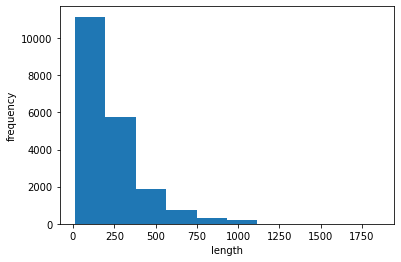

In [16]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

치우쳐져있다. 대부분 리뷰 길이는 300 미만. 하지만 어떤 리뷰는 1000개가 넘어가기도 한다. ->    
리뷰는 대부분 짧아서 중간값보다 훨씬 짧은 100개의 단어만 사용하겠다.

In [17]:
# 시퀀스 데이터의 길이 100으로 맞추기 (pad_sequences)

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # 보통 앞에서부터 자른다.

In [18]:
print(train_seq.shape) # 성공

(20000, 100)


In [19]:
val_seq = pad_sequences(val_input,maxlen=100)

순환 신경망 모델 만들기

In [27]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100,500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

단순하게 숫자를 100으로 일치시켰기 때문에 정숫값 100을 입력하기 위해서는 다른 방식을 찾아야 한다.
-> 원핫인코딩

In [23]:
from tensorflow import keras

In [24]:
train_oh = keras.utils.to_categorical(train_seq) # 원핫인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 훈련하기

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',save_best_only=True)

In [33]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb]
                    )

Epoch 1/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5202 - accuracy: 0.7701 - val_loss: 0.5253 - val_accuracy: 0.7612
Epoch 2/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5102 - accuracy: 0.7770 - val_loss: 0.5142 - val_accuracy: 0.7688
Epoch 3/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5002 - accuracy: 0.7824 - val_loss: 0.5096 - val_accuracy: 0.7642
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4921 - accuracy: 0.7851 - val_loss: 0.5007 - val_accuracy: 0.7726
Epoch 5/100
313/313 [==============================] - 13s 41ms/step - loss: 0.4840 - accuracy: 0.7891 - val_loss: 0.4955 - val_accuracy: 0.7728
Epoch 6/100
313/313 [==============================] - 13s 43ms/step - loss: 0.4771 - accuracy: 0.7921 - val_loss: 0.4898 - val_accuracy: 0.7778
Epoch 7/100
313/313 [==============================] - 13s 40ms/step - loss: 0.4706 - accuracy: 0.7954 - val_loss: 0.4841 - val_ac

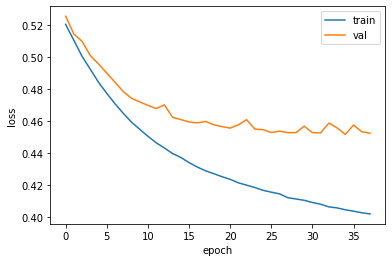

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()